
TRABAJO PRÁCTICO N° 2 - Procesamiento de Imágenes I

**Estudiantes:**

  - Alejandro Armas
  - Facundo Ferreira daCamara
  - Gabriel Soda

# Introducción

El presente trabajo práctico tiene como objetivo el desarrollo de algoritmos de visión por computadora para resolver problemas de segmentación, detección y clasificación automática de objetos.

A continuación se describen los dos problemas planteados para este entregable:

### Problema 1: Detección y clasificación de monedas y dados

Este ejercicio propone el análisis de la imagen `monedas.jpg`, la cual presenta un escenario con un fondo de intensidad no uniforme donde se encuentran dispersos dados y monedas de distintos tamaños y valores.

Los objetivos específicos son:

1.  **Segmentación:** Separar automáticamente las monedas y los dados del fondo.
2.  **Clasificación de monedas:** Identificar los tipos de monedas y realizar su conteo.
3.  **Lectura de dados:** Determinar el número de la cara superior y contabilizar.


# Desarrollo del Problema 1

## 1\. Carga y Análisis Inicial

Para comenzar, cargamos la imagen en escala de grises y analizamos su histograma e intensidades. Definimos también una función auxiliar `imshow` para visualizar los resultados a lo largo del informe.

In [1]:
# importacion de librerias
import cv2
import numpy as np
import matplotlib.pyplot as plt

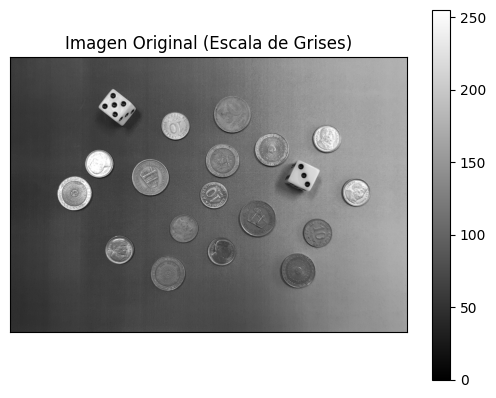

In [2]:
# función para mostrar las imágenes
def imshow(img, new_fig=True, title=None, color_img=False, blocking=True, colorbar=True, ticks=False):
    if new_fig:
        plt.figure()
    if color_img:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    if not ticks:
        plt.xticks([]), plt.yticks([])
    if colorbar:
        plt.colorbar()
    if new_fig:        
        plt.show(block=blocking)

mon = cv2.imread('monedas.jpg', cv2.IMREAD_GRAYSCALE)
imshow(mon, title="Imagen Original (Escala de Grises)")


**Resultado:**

  * Se observa la imagen original cargada correctamente.
  * *Observación:* La imagen presenta ruido y un fondo texturizado que podría dificultar la segmentación simple por umbralado global.


## 2\. Pre-procesamiento y Selección de Detector de Bordes

Nuestro primer enfoque fue utilizar **HoughCircles**, pero requiere bordes muy bien definidos.
Probamos inicialmente con **Sobel** y **Laplaciano de Gauss (LoG)**. Sin embargo, estos métodos resultaron muy sensibles al ruido del fondo o requerían un post-procesamiento (umbralado y filtros de mediana) complejo para limpiar la imagen.

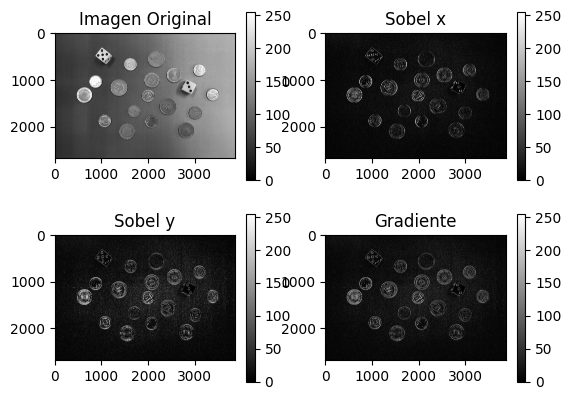

In [3]:
# deteccion de bordes con gradiente
ddepth = cv2.CV_16S
grad_x = cv2.Sobel(mon, ddepth, 1, 0, ksize=3)
grad_y = cv2.Sobel(mon, ddepth, 0, 1, ksize=3)
np.unique(grad_x)
np.unique(grad_y)

# Acondicionamiento
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 

plt.figure()
ax = plt.subplot(221)
imshow(mon, new_fig=False, title="Imagen Original", ticks=True)
plt.subplot(222, sharex=ax, sharey=ax), imshow(abs_grad_x, new_fig=False, title="Sobel x", ticks=True)
plt.subplot(223, sharex=ax, sharey=ax), imshow(abs_grad_y, new_fig=False, title="Sobel y", ticks=True)
plt.subplot(224, sharex=ax, sharey=ax), imshow(grad, new_fig=False, title="Gradiente", ticks=True)
plt.show(block=False)

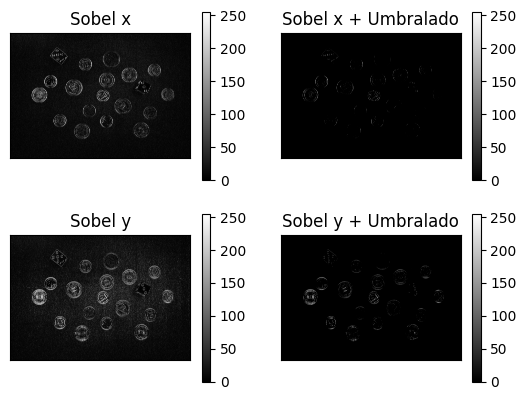

In [4]:
# Umbralizamos los gradientes 
abs_grad_x_th = np.zeros_like(abs_grad_x) 
abs_grad_x_th[abs_grad_x == abs_grad_x.max()] = 255

abs_grad_y_th = np.zeros_like(abs_grad_y) 
abs_grad_y_th[abs_grad_y == abs_grad_y.max()] = 255

grad_th = np.zeros_like(grad) 
grad_th[grad >= 0.5*grad.max()] = 255

plt.figure()
ax = plt.subplot(221)
imshow(abs_grad_x, new_fig=False, title="Sobel x")
plt.subplot(222, sharex=ax, sharey=ax), imshow(abs_grad_x_th, new_fig=False, title="Sobel x + Umbralado")
plt.subplot(223, sharex=ax, sharey=ax), imshow(abs_grad_y, new_fig=False, title="Sobel y")
plt.subplot(224, sharex=ax, sharey=ax), imshow(abs_grad_y_th, new_fig=False, title="Sobel y + Umbralado")
plt.show(block=False)

Como es posible observan en los resultados, tanto sobel, como sobel + umbralado, no consigen destacar los bordes de los objetos
sin mucho ruido del fondo.
Esto se debe principalmente a la uniformidad del fondo.

Antes de aplicar la Transformada de Hough, realizamos un análisis de bordes 
mediante el algoritmo Canny para determinar la sensibilidad adecuada.

Previa a la detección, aplicamos un `GaussianBlur` para suavizar aún más la 
textura de la mesa.

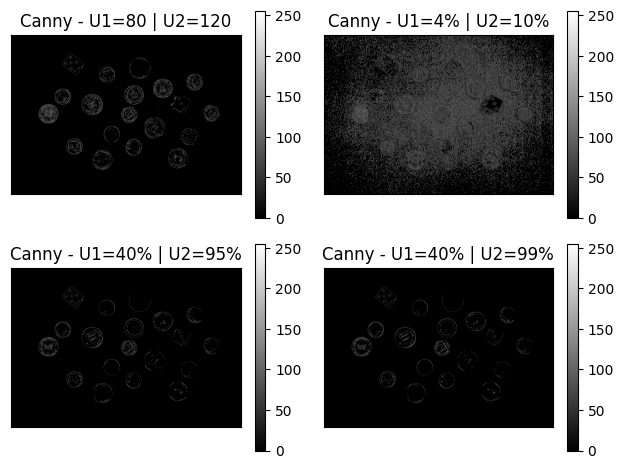

In [5]:

# Canny
mon = cv2.imread('monedas.jpg', cv2.IMREAD_GRAYSCALE) # cargo de nuevo por si alguna función anterior sobreescribió
f_blur = cv2.GaussianBlur(mon, ksize=(5, 5), sigmaX=1.5)

gcan = cv2.Canny(f_blur, threshold1=80, threshold2=120)

gcan1 = cv2.Canny(f_blur, threshold1=0.04*255, threshold2=0.1*255)
gcan2 = cv2.Canny(f_blur, threshold1=0.4*255, threshold2=0.95*255)
gcan3 = cv2.Canny(f_blur, threshold1=0.4*255, threshold2=0.99*255)

plt.figure()
ax = plt.subplot(221)
imshow(gcan, new_fig=False, title="Canny - U1=80 | U2=120")
plt.subplot(222, sharex=ax, sharey=ax)
imshow(gcan1, new_fig=False, title="Canny - U1=4% | U2=10%")
plt.subplot(223, sharex=ax, sharey=ax)
imshow(gcan2, new_fig=False, title="Canny - U1=40% | U2=95%")
plt.subplot(224, sharex=ax, sharey=ax)
imshow(gcan3, new_fig=False, title="Canny - U1=40% | U2=99%")
plt.tight_layout()
plt.show(block=False)

Ahora mostramos la imagen que mejor resultados presentó

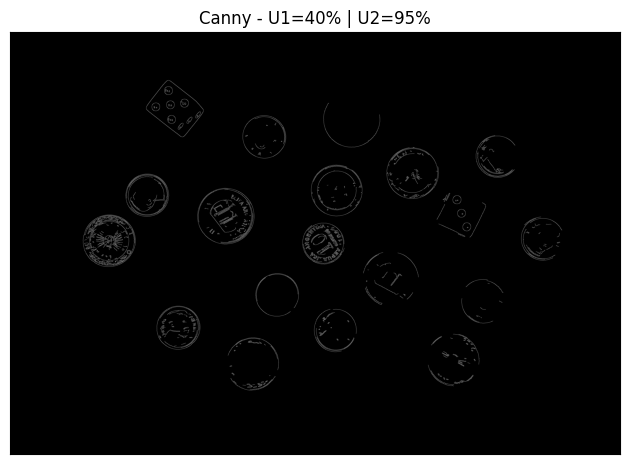

In [6]:
plt.figure()
imshow(gcan2, new_fig=False, title="Canny - U1=40% | U2=95%", colorbar=False)
plt.tight_layout()
plt.show(block=False)


**Análisis del Resultado:**

  * La imagen resultante muestra los contornos de las monedas suficientemente bien y los dados claramente definidos.
  * Los umbrales altos ($0.99*255$) ayudaron a eliminar gran parte de la textura de la madera de la mesa, 
dejando principalmente los bordes fuertes de los objetos que sí interesan.

Para determinar el parámetro `param1` de la función HoughCircles, realizamos un estudio previo utilizando 
el detector de bordes Canny de forma aislada (ver figuras `gcan2` y `gcan3`).

Observamos que la combinación de umbrales [102, 242] (correspondientes al 40% y 95% de intensidad) 
lograba aislar los bordes de las monedas eliminando el ruido de la textura de madera.

Dado que HoughCircles utiliza `param1` como umbral superior y `param1/2` como inferior para su detección de 
bordes interna, configuramos `param1=200`. Esto establece implícitamente un umbral inferior de 100, 
replicando casi con exactitud los valores óptimos encontrados en nuestra experimentación manual (102), 
pero con un umbral superior ligeramente más relajado (200 vs 242) para asegurar 
la continuidad de los bordes circulares.


## 3\. Detección y Clasificación de Monedas

Con los bordes definidos, utilizamos la **Transformada de Hough para Círculos**. 
Realizamos una primera pasada configurada específicamente para detectar los radios grandes correspondientes a las monedas.

Implementamos una lógica de clasificación basada en el radio detectado para distinguir entre monedas de 10 centavos, 
1 peso y 50 centavos.

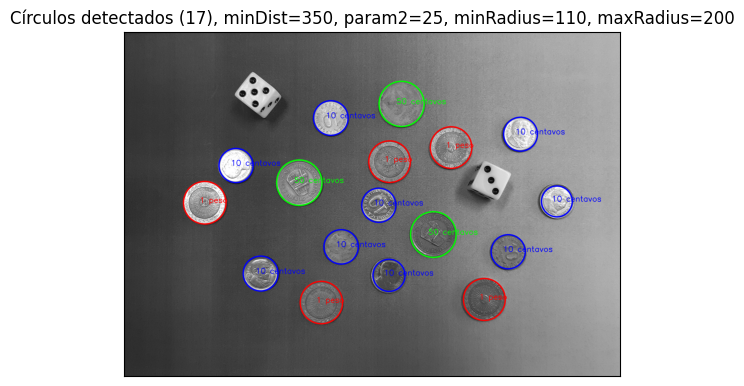

In [31]:
from collections import defaultdict

# Configuración para detectar MONEDAS
minDist = 350      # Distancia mínima entre centros
param2 = 25        # Umbral del acumulador (mientras más bajo, menos riguroso para detectar círculos)
minRadius = 110    # Radio mínimo esperado
maxRadius = 200    # Radio máximo esperado
circles = cv2.HoughCircles(f_blur, 
                           method=cv2.HOUGH_GRADIENT, 
                           dp=1, 
                           minDist=minDist,
                           param1=200, # Umbral alto de Canny (pasado a la función)
                           param2=param2, 
                           minRadius=minRadius,
                           maxRadius=maxRadius)

Nc = circles.shape[1]
# Dibujo los círculos detectados
circles = np.uint16(np.around(circles))
fc = cv2.cvtColor(mon, cv2.COLOR_GRAY2RGB) # Imagen color para dibujar resultados

monedas = defaultdict(int)

def identificar_moneda(radio):
    if radio < 140:
        monedas[10] += 1
        return (0,0,255), "10 centavos" # Rojo
    elif radio < 170:
        monedas[100] += 1
        return (255,0,0), "1 peso"      # Azul
    else:
        monedas[50] += 1
        return (0,255,0), "50 centavos" # Verde


# Dibujado y clasificación
if circles is not None:
    for c in circles[0,:]:
        radio = c[2]
        color, tipo = identificar_moneda(radio)
        # Dibujar círculo y texto
        cv2.circle(fc, (c[0],c[1]), radio, color, 10)
        cv2.putText(fc, tipo, (c[0]-40, c[1]), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 3)

imshow(fc, colorbar=False, title=f"Círculos detectados ({Nc}), minDist={minDist}, param2={param2}, minRadius={minRadius}, maxRadius={maxRadius}")


**Análisis:**

  * Los parámetros `minRadius` y `maxRadius` permitieron filtrar los puntos de los dados (que son círculos pequeños), quedándonos solo con las monedas.


## 4\. Detección y Lectura de Dados

Para los dados, se presenta un doble problema: detectar los puntos y agruparlos para saber a qué dado pertenecen.

1.  **Detección:** Realizamos una segunda pasada de `HoughCircles` con radios muy pequeños (25-27 px).
2.  **Agrupamiento:** Creamos una clase `Dado` para poder identificar cada dado de la imágen y contar sus valores. Usamos un algoritmo muy simple que itera sobre todos los puntos de dados, de izquierda a derecha, y asume que los puntos que están cerca pertenecen al mismo dado y que todos los dados cubren un rango distinto del eje horizontal, los dados encontrados son en realidad conjuntos de puntos pequeños encontrados. La imágen a analizar en cuestión cumple con esos requisitos por lo que la deteccion funciona bien, aunque es un algoritmo muy poco robusto.

In [ ]:
# Configuración para detectar circulos pequeños de dados
minDist = 40
param2 = 20
minRadius = 25
maxRadius = 27

circles = cv2.HoughCircles(f_blur, 
                           method=cv2.HOUGH_GRADIENT, 
                           dp=1, 
                           minDist=minDist, 
                           param2=param2,
                           minRadius=minRadius,
                           maxRadius=maxRadius)  

Nc = circles.shape[1]
# Dibujo los círculos detectados
circles = np.uint16(np.around(circles))

class Dado():
    def __init__(self, x, y):
        self.min_x = x
        self.min_y = y
        self.max_x = x
        self.max_y = y
        self.valor = 1

    def actualizar(self, x, y):
        if x < self.min_x:
            self.min_x = x
        if x > self.max_x:
            self.max_x = x
        if y < self.min_y:
            self.min_y = y
        if y > self.max_y:
            self.max_y = y
        self.valor += 1

# Lógica de agrupación
circulos = sorted(circles[0,:], key=lambda c: c[0])  # ordeno por posición x
dados = []
distancia_anterior = 0

for c in circulos:
    x, y = c[0], c[1]
    distancia = np.hypot(x, y)
    cv2.circle(fc, (c[0],c[1]), c[2], (255,0,255), 2)
    # print(distancia, distancia_anterior)
    if abs(distancia - distancia_anterior) > 200:  # si la distancia es suficientemente distinta, es otro dado
        d = Dado(x, y)
        dados.append(d)
        distancia_anterior = distancia
    else:
        d.actualizar(x, y)

for d in dados:
    cx = (d.min_x + d.max_x) // 2
    cy = (d.min_y + d.max_y) // 2
    max_radio = max(d.max_x - d.min_x, d.max_y - d.min_y) // 2
    cv2.rectangle(fc, (d.min_x - max_radio, d.min_y - max_radio), (d.max_x + max_radio, d.max_y + max_radio), (255,0,255), 5) # Estimación de bounding box de cada dado
    cv2.putText(fc, f"Valor {d.valor}", (d.min_x - max_radio, d.min_y - max_radio - 10), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,255), 5)


## 5\. Resultados Finales

Integramos ambas detecciones (monedas y dados) en la imagen final.

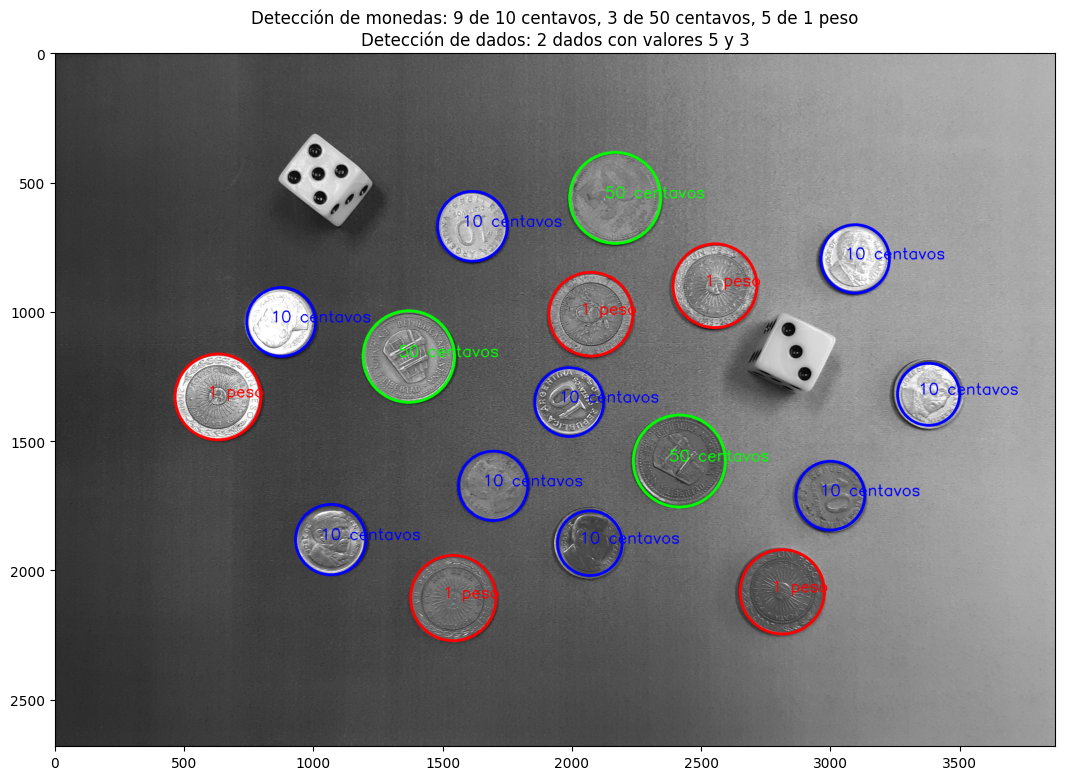

In [37]:
fig, ax = plt.subplots(figsize=(16, 9))


texto_titulo = f"Detección de monedas: {monedas[10]} de 10 centavos, {monedas[50]} de 50 centavos, {monedas[100]} de 1 peso"
texto_titulo += f"\nDetección de dados: {len(dados)} dados con valores {' y '.join(str(d.valor) for d in dados)}"

ax.imshow(fc) 
plt.title(texto_titulo)
plt.tight_layout
plt.show()


**Conclusión del Problema 1:**
El uso de la Transformada de Hough en dos etapas (una para radios grandes y otra para radios pequeños), combinado con un filtrado previo mediante Canny, demostró ser una estrategia efectiva.

  * Se logró clasificar correctamente las monedas por su tamaño.
  * Se logró agrupar los puntos e identificar los dados utilizando proximidad espacial, permitiendo calcular sus valores automáticamente.